In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt

In [6]:
import tensorflow_datasets as tfds

# Specify the directory where you want to download the dataset
data_dir = "flowers102"

# Load the Oxford Flowers 102 dataset
dataset, info = tfds.load('oxford_flowers102', data_dir=data_dir, with_info=True, as_supervised=True)

# Print information about the dataset
print(info)

# Access the training, validation, and test sets
train_dataset = dataset['train']
validation_dataset = dataset['validation']
test_dataset = dataset['test']


tfds.core.DatasetInfo(
    name='oxford_flowers102',
    full_name='oxford_flowers102/2.1.1',
    description="""
    The Oxford Flowers 102 dataset is a consistent of 102 flower categories commonly
    occurring in the United Kingdom. Each class consists of between 40 and 258
    images. The images have large scale, pose and light variations. In addition,
    there are categories that have large variations within the category and several
    very similar categories.
    
    The dataset is divided into a training set, a validation set and a test set. The
    training set and validation set each consist of 10 images per class (totalling
    1020 images each). The test set consists of the remaining 6149 images (minimum
    20 per class).
    
    Note: The dataset by default comes with a test size larger than the train size.
    For more info see this
    [issue](https://github.com/tensorflow/datasets/issues/3022).
    """,
    homepage='https://www.robots.ox.ac.uk/~vgg/data/flowers/102

In [12]:
class_names = info.features['label'].names

# Function to display images with their corresponding names
def display_images_with_names(dataset, num_images):
    plt.figure(figsize=(15, 15))
    for i, (image, label) in enumerate(dataset.take(num_images)):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(image)
        plt.title(f"{class_names[label.numpy()]}")
        plt.axis("off")
    plt.show()


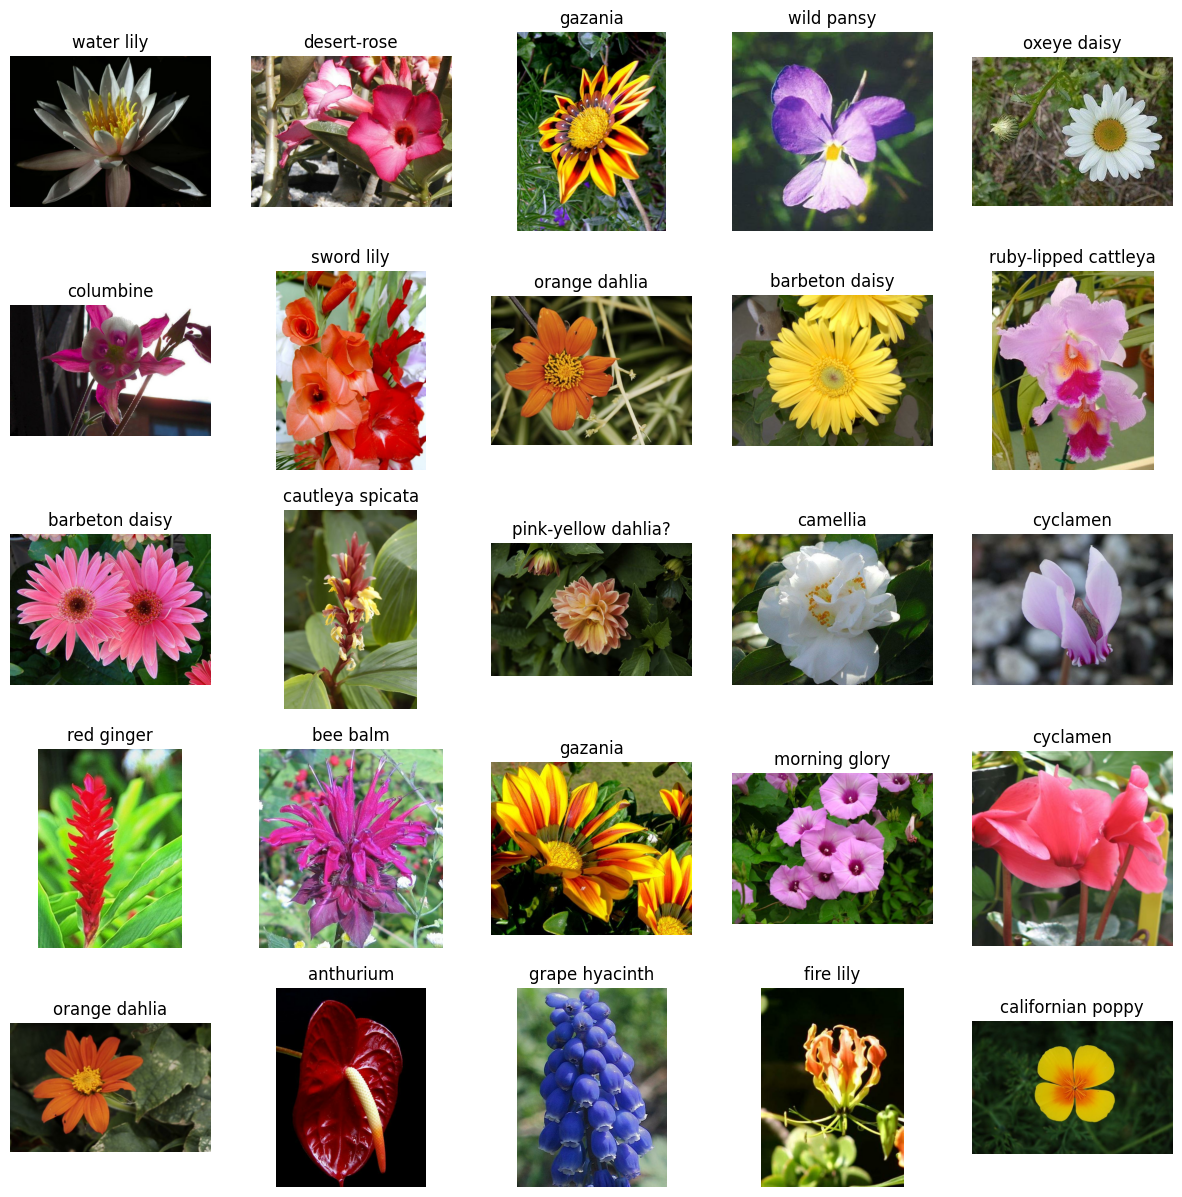

In [5]:
display_images_with_names(train_dataset, 25)

# Preprocessing

In [7]:
# Apply the preprocessing to the datasets
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
def preprocess(image, label):
    # Resize the image
    image = tf.image.resize(image, IMG_SIZE)
    # Normalize the image
    #image = image / 255.0
    return image, label
train_dataset = train_dataset.map(preprocess).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
validation_dataset = validation_dataset.map(preprocess).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.map(preprocess).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

In [6]:
class_names

['pink primrose',
 'hard-leaved pocket orchid',
 'canterbury bells',
 'sweet pea',
 'english marigold',
 'tiger lily',
 'moon orchid',
 'bird of paradise',
 'monkshood',
 'globe thistle',
 'snapdragon',
 "colt's foot",
 'king protea',
 'spear thistle',
 'yellow iris',
 'globe-flower',
 'purple coneflower',
 'peruvian lily',
 'balloon flower',
 'giant white arum lily',
 'fire lily',
 'pincushion flower',
 'fritillary',
 'red ginger',
 'grape hyacinth',
 'corn poppy',
 'prince of wales feathers',
 'stemless gentian',
 'artichoke',
 'sweet william',
 'carnation',
 'garden phlox',
 'love in the mist',
 'mexican aster',
 'alpine sea holly',
 'ruby-lipped cattleya',
 'cape flower',
 'great masterwort',
 'siam tulip',
 'lenten rose',
 'barbeton daisy',
 'daffodil',
 'sword lily',
 'poinsettia',
 'bolero deep blue',
 'wallflower',
 'marigold',
 'buttercup',
 'oxeye daisy',
 'common dandelion',
 'petunia',
 'wild pansy',
 'primula',
 'sunflower',
 'pelargonium',
 'bishop of llandaff',
 'gaura',

# Model 1

In [29]:
base_model = tf.keras.applications.EfficientNetV2B0(include_top=False)
base_model.trainable = False

inputs = tf.keras.layers.Input(shape=(224,224,3),name="input_layer")

x = base_model(inputs)

print(f"Shape after base_model: {x.shape}")
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"After GlobalAveragePooling2D(): {x.shape}")
outputs = tf.keras.layers.Dense(102,activation="softmax",name = "output_layer")(x)

model_1 = tf.keras.Model(inputs,outputs)
model_1.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

with tf.device('/GPU:0'):
    history = model_1.fit(train_dataset,
                                 epochs=5,
                               
                                 validation_data=validation_dataset
                                 #validation_steps=int(0.25 * len(test_dataset))
                                 
                                )



Shape after base_model: (None, 7, 7, 1280)
After GlobalAveragePooling2D(): (None, 1280)
Epoch 1/5
32/32 [==============================] - 25s 558ms/step - loss: 4.3234 - accuracy: 0.1225 - val_loss: 3.5651 - val_accuracy: 0.4382
Epoch 2/5
32/32 [==============================] - 13s 374ms/step - loss: 2.9530 - accuracy: 0.6647 - val_loss: 2.6960 - val_accuracy: 0.6559
Epoch 3/5
32/32 [==============================] - 26s 834ms/step - loss: 2.0884 - accuracy: 0.8314 - val_loss: 2.1097 - val_accuracy: 0.7333
Epoch 4/5
32/32 [==============================] - 27s 858ms/step - loss: 1.5091 - accuracy: 0.9029 - val_loss: 1.7299 - val_accuracy: 0.7873
Epoch 5/5
32/32 [==============================] - 27s 852ms/step - loss: 1.1369 - accuracy: 0.9363 - val_loss: 1.4769 - val_accuracy: 0.8029


In [49]:
model_1.evaluate(test_dataset)

193/193 [==============================] - 21s 106ms/step - loss: 1.6196 - accuracy: 0.7792


[1.6196290254592896, 0.7791510820388794]

# Model 2 : Data Aug

In [13]:
import tensorflow_datasets as tfds
data_dir = "flowers102"

# Load the dataset
#(dataset_train, dataset_test), ds_info = tfds.load('oxford_flowers102', data_dir=data_dir, split=['train[:80%]', 'train[80%:]'], with_info=True, as_supervised=True)
dataset, info = tfds.load('oxford_flowers102', data_dir=data_dir, with_info=True, as_supervised=True)
# Define class names
dataset_train = dataset['train']
dataset_validation = dataset['validation']
dataset_test = dataset['test']
#class_names = ds_info.features['label'].names

# Define data augmentation and preprocessing functions
def data_augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
    image = tf.image.random_saturation(image, lower=0.9, upper=1.1)
    image = tf.image.random_hue(image, max_delta=0.1)
    return image, label

def preprocess(image, label):
    image = tf.image.resize(image, (224, 224))  # Resize images to 224x224
    
    return image, label

# Apply data augmentation and preprocessing to the training dataset
dataset_train = dataset_train.map(data_augment, num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset_train = dataset_train.map(preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset_train = dataset_train.shuffle(1000).batch(32).prefetch(tf.data.experimental.AUTOTUNE)

# Preprocess the test dataset
dataset_test = dataset_test.map(preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset_test = dataset_test.batch(32).prefetch(tf.data.experimental.AUTOTUNE)


In [17]:
# Load the base model with EfficientNetV2B0
base_model = tf.keras.applications.EfficientNetV2B0(include_top=False)
base_model.trainable = False

# Define the input layer
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# Pass inputs through the base model
x = base_model(inputs)
print(f"Shape after base_model: {x.shape}")

# Apply GlobalAveragePooling2D
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D(): {x.shape}")

# Add the output layer with the correct number of classes (102 for tf_flowers)
outputs = tf.keras.layers.Dense(102, activation="softmax", name="output_layer")(x)

# Create the model
model_2 = tf.keras.Model(inputs, outputs)

# Compile the model
model_2.compile(loss='sparse_categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Print model summary
model_2.summary()


Shape after base_model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D(): (None, 1280)
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Function  (None, None, None, 1280)  5919312  
 al)                                                             
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 102)               130662    
                                                                 
Total params: 6,049,974
Trainable params: 130,662
Non-trainable params: 5,919,312
_______________

In [25]:
# Train the model
with tf.device('/GPU:0'):
    history2 = model_2.fit(dataset_train,
                           epochs=5,
                           validation_data=dataset_test)


Epoch 1/5
32/32 [==============================] - 46s 1s/step - loss: 4.3570 - accuracy: 0.0922 - val_loss: 4.3324 - val_accuracy: 0.1028
Epoch 2/5
32/32 [==============================] - 51s 1s/step - loss: 4.1238 - accuracy: 0.1990 - val_loss: 4.1323 - val_accuracy: 0.1984
Epoch 3/5
32/32 [==============================] - 46s 1s/step - loss: 3.8867 - accuracy: 0.3049 - val_loss: 3.9188 - val_accuracy: 0.2913
Epoch 4/5
32/32 [==============================] - 45s 1s/step - loss: 3.6555 - accuracy: 0.4010 - val_loss: 3.7164 - val_accuracy: 0.3723
Epoch 5/5
32/32 [==============================] - 82s 2s/step - loss: 3.3987 - accuracy: 0.5098 - val_loss: 3.5032 - val_accuracy: 0.4417


In [10]:
def load_and_prep_image(filename, img_shape=224, scale=True):
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode it into a tensor
  img = tf.io.decode_image(img,channels = 3)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    # Rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img

1/1 [==============================] - 2s 2s/step


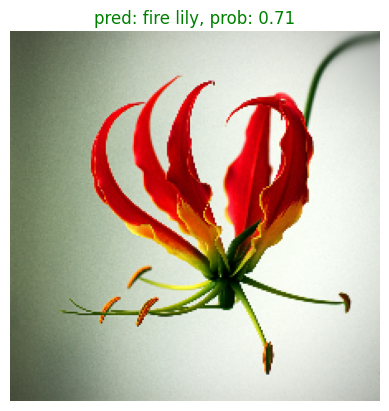

In [32]:
# Make preds on a series of random images
import os
import random
import matplotlib.pyplot as plt


  #class_name = random.choice(class_names)
  #filename = random.choice(os.listdir(test_dir + "/" + class_name))
filepath = "flower-6608065_1280.jpg"

  # Load the image and make predictions
img = load_and_prep_image(filepath, scale=False) # don't scale images for EfficientNet predictions
pred_prob = model_2.predict(tf.expand_dims(img, axis=0)) # model accepts tensors of shape [None, 224, 224, 3]
pred_class = class_names[pred_prob.argmax()] # find the predicted class

  #Plot the image(s)
  #plt.subplot(3, 1, i+1)
plt.imshow(img/255.)
# Change the color of text based on whether prediction is right or wrong
title_color = "g"

   
plt.title(f"pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
plt.axis(False);

# Model 1 : Fine tuning

In [20]:
base_model.trainable = True
for layer in base_model.layers[:-10]:
    layer.trainable = False

model_1.compile(loss='sparse_categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # lr is 10x lower than before for fine-tuning
                metrics=["accuracy"])

In [21]:
print(len(model_1.trainable_variables))

12


In [22]:
fine_tune_epochs = 5 + 5

In [30]:
# Train the model
with tf.device('/GPU:0'):
    history3 = model_1.fit(train_dataset,
                           epochs=fine_tune_epochs,
                           validation_data=validation_dataset,
                           initial_epoch=history.epoch[-1])


Epoch 5/10
32/32 [==============================] - 19s 618ms/step - loss: 0.8852 - accuracy: 0.9559 - val_loss: 1.3014 - val_accuracy: 0.8235
Epoch 6/10
32/32 [==============================] - 20s 621ms/step - loss: 0.7170 - accuracy: 0.9696 - val_loss: 1.1719 - val_accuracy: 0.8392
Epoch 7/10
32/32 [==============================] - 27s 844ms/step - loss: 0.5832 - accuracy: 0.9775 - val_loss: 1.0742 - val_accuracy: 0.8461
Epoch 8/10
32/32 [==============================] - 20s 642ms/step - loss: 0.4823 - accuracy: 0.9814 - val_loss: 0.9995 - val_accuracy: 0.8451
Epoch 9/10
32/32 [==============================] - 21s 632ms/step - loss: 0.4078 - accuracy: 0.9902 - val_loss: 0.9362 - val_accuracy: 0.8461
Epoch 10/10
32/32 [==============================] - 20s 592ms/step - loss: 0.3638 - accuracy: 0.9912 - val_loss: 0.8848 - val_accuracy: 0.8539


In [35]:
class_names = info.features['label'].names
class_names

['pink primrose',
 'hard-leaved pocket orchid',
 'canterbury bells',
 'sweet pea',
 'english marigold',
 'tiger lily',
 'moon orchid',
 'bird of paradise',
 'monkshood',
 'globe thistle',
 'snapdragon',
 "colt's foot",
 'king protea',
 'spear thistle',
 'yellow iris',
 'globe-flower',
 'purple coneflower',
 'peruvian lily',
 'balloon flower',
 'giant white arum lily',
 'fire lily',
 'pincushion flower',
 'fritillary',
 'red ginger',
 'grape hyacinth',
 'corn poppy',
 'prince of wales feathers',
 'stemless gentian',
 'artichoke',
 'sweet william',
 'carnation',
 'garden phlox',
 'love in the mist',
 'mexican aster',
 'alpine sea holly',
 'ruby-lipped cattleya',
 'cape flower',
 'great masterwort',
 'siam tulip',
 'lenten rose',
 'barbeton daisy',
 'daffodil',
 'sword lily',
 'poinsettia',
 'bolero deep blue',
 'wallflower',
 'marigold',
 'buttercup',
 'oxeye daisy',
 'common dandelion',
 'petunia',
 'wild pansy',
 'primula',
 'sunflower',
 'pelargonium',
 'bishop of llandaff',
 'gaura',

1/1 [==============================] - 0s 39ms/step


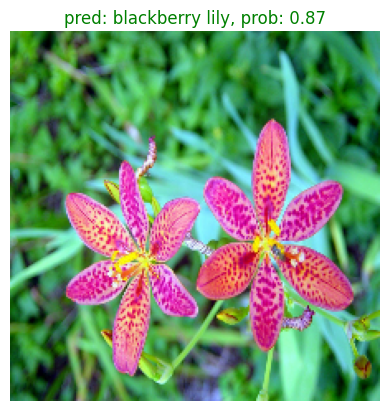

In [38]:
# Make preds on a series of random images
import os
import random
import matplotlib.pyplot as plt


  #class_name = random.choice(class_names)
  #filename = random.choice(os.listdir(test_dir + "/" + class_name))
filepath = "Belamcanda-Blackberry-Lily-Leopard-Lily-2.jpg"

  # Load the image and make predictions
img = load_and_prep_image(filepath, scale=False) # don't scale images for EfficientNet predictions
pred_prob = model_1.predict(tf.expand_dims(img, axis=0)) # model accepts tensors of shape [None, 224, 224, 3]
pred_class = class_names[pred_prob.argmax()] # find the predicted class

  #Plot the image(s)
  #plt.subplot(3, 1, i+1)
plt.imshow(img/255.)
# Change the color of text based on whether prediction is right or wrong
title_color = "g"

   
plt.title(f"pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
plt.axis(False);

In [39]:
model_1.save("flowers102_model")

INFO:tensorflow:Assets written to: flowers102_model\assets


INFO:tensorflow:Assets written to: flowers102_model\assets


In [2]:
model = tf.keras.models.load_model('flowers102_model')

In [8]:
model.evaluate(test_dataset)

193/193 [==============================] - 26s 114ms/step - loss: 1.0036 - accuracy: 0.8294


[1.0035876035690308, 0.8294031620025635]

1/1 [==============================] - 0s 40ms/step
[[1.34380162e-03 4.92802705e-04 3.81693360e-04 2.26360964e-04
  4.48117644e-04 1.66304671e-04 7.85204466e-05 5.85315138e-05
  1.60175041e-04 1.23325182e-04 2.31700076e-04 7.68666214e-05
  8.52336525e-05 2.95765603e-05 1.03746344e-04 1.24429271e-05
  1.89749396e-03 1.76103599e-03 1.10495801e-03 1.48851786e-05
  1.06072017e-04 8.14016457e-05 4.69054765e-04 2.78666499e-04
  3.77662160e-04 5.39216038e-04 7.30678148e-05 5.09732403e-04
  4.24859209e-05 1.95642118e-04 1.19269163e-04 5.67331328e-04
  2.82938272e-04 2.66758632e-03 1.74910849e-04 2.46115669e-04
  1.64400175e-04 1.63101556e-03 7.31422857e-04 1.12078665e-03
  1.46354418e-04 7.06589126e-05 1.17954602e-04 1.89776602e-03
  2.15968485e-05 1.00500425e-02 1.57327362e-04 8.56892148e-05
  2.44721450e-04 3.12885066e-04 2.21272552e-04 3.13634053e-03
  1.15688788e-04 4.28482890e-05 5.18001209e-04 1.97359407e-03
  3.11980257e-03 4.42107994e-05 5.23225230e-04 1.10633997e-03
  2.55262101e-04 8

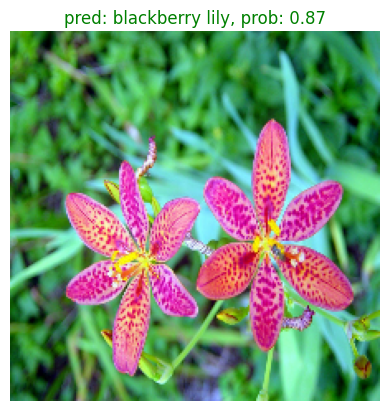

In [15]:
# Make preds on a series of random images
import os
import random
import matplotlib.pyplot as plt


  #class_name = random.choice(class_names)
  #filename = random.choice(os.listdir(test_dir + "/" + class_name))
filepath = "Belamcanda-Blackberry-Lily-Leopard-Lily-2.jpg"

  # Load the image and make predictions
img = load_and_prep_image(filepath, scale=False) # don't scale images for EfficientNet predictions
pred_prob = model.predict(tf.expand_dims(img, axis=0)) # model accepts tensors of shape [None, 224, 224, 3]
print(pred_prob, pred_prob.argmax())
pred_class = class_names[pred_prob.argmax()] # find the predicted class

  #Plot the image(s)
  #plt.subplot(3, 1, i+1)
plt.imshow(img/255.)
# Change the color of text based on whether prediction is right or wrong
title_color = "g"

   
plt.title(f"pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
plt.axis(False);

In [17]:
class_names[48]

'oxeye daisy'